
# Gözetimsiz Öğrenme ile Müşteri Segmentasyonu
# (Customer Segmentation with Unsupervised Learning)




Online ayakkabı mağazası olan FLO müşterilerini segmentlere ayırıp bu segmentlere göre pazarlama stratejileri belirlemek istiyor. Buna yönelik olarak müşterilerin davranışları tanımlanacak ve bu davranışlardaki öbeklenmelere göre gruplar oluşturulacak


FLO wants to divide its customers into segments and determine marketing strategies according to these segments. For this purpose, the behaviors of the customers will be defined and groups will be formed according to the clusters in these behaviors.

Objectives:

After some data exploratory analysis, I will deploy two different clustering algorithms and visualize the results:

* Use scikit-learn K-Means clustering and
* Use scikit-learn Hierarchical clustering and create dendograms to visualize the clustering

In [5]:
#define the library
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import warnings
from scipy import stats

from sklearn.exceptions import ConvergenceWarning

from sklearn.preprocessing import MinMaxScaler

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage

from yellowbrick.cluster import KElbowVisualizer

from sklearn.metrics import silhouette_score


In [6]:
# make some settings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.width', 1000)

In [7]:
# reading the dataset
# flo is the original dataset

flo = pd.read_csv("C:/Users/avcil/projects/project/flo_data.csv")  


# flo = pd.read_csv("/kaggle/input/flo-data/flo_data_20k.csv")
# df = flo.copy()

In [8]:
flo.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.00,1.00,139.99,799.38,[KADIN]
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.00,2.00,159.97,1853.58,"[ERKEK, COCUK, KADIN, AKTIFSPOR]"
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.00,2.00,189.97,395.35,"[ERKEK, KADIN]"
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.00,1.00,39.99,81.98,"[AKTIFCOCUK, COCUK]"
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.00,1.00,49.99,159.99,[AKTIFSPOR]


In [9]:
# create a copy of flo dataset
df = flo.copy()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   master_id                          19945 non-null  object 
 1   order_channel                      19945 non-null  object 
 2   last_order_channel                 19945 non-null  object 
 3   first_order_date                   19945 non-null  object 
 4   last_order_date                    19945 non-null  object 
 5   last_order_date_online             19945 non-null  object 
 6   last_order_date_offline            19945 non-null  object 
 7   order_num_total_ever_online        19945 non-null  float64
 8   order_num_total_ever_offline       19945 non-null  float64
 9   customer_value_total_ever_offline  19945 non-null  float64
 10  customer_value_total_ever_online   19945 non-null  float64
 11  interested_in_categories_12        19945 non-null  obj

In [11]:
# Converting data containing date information to datetime type
date_columns = df.columns[df.columns.str.contains("date")]
df[date_columns] = df[date_columns].apply(pd.to_datetime)

In [12]:
#check chancing
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   master_id                          19945 non-null  object        
 1   order_channel                      19945 non-null  object        
 2   last_order_channel                 19945 non-null  object        
 3   first_order_date                   19945 non-null  datetime64[ns]
 4   last_order_date                    19945 non-null  datetime64[ns]
 5   last_order_date_online             19945 non-null  datetime64[ns]
 6   last_order_date_offline            19945 non-null  datetime64[ns]
 7   order_num_total_ever_online        19945 non-null  float64       
 8   order_num_total_ever_offline       19945 non-null  float64       
 9   customer_value_total_ever_offline  19945 non-null  float64       
 10  customer_value_total_ever_online  

In [13]:
df["last_order_date"].max() 
# output 2021-05-30 

Timestamp('2021-05-30 00:00:00')

In [14]:
# determined the last_date
last_date = dt.datetime(2021,6,1)

In [15]:
# create a new variable called recency
df["recency"] = (last_date - df["last_order_date"]).astype('timedelta64[D]')

# recency: It keeps information on how many days ago the person last shopped.
# Recency shows when our customer last shopped from our brand.

In [16]:
# create a new variable called tenure
df["tenure"] = (df["last_order_date"]-df["first_order_date"]).astype('timedelta64[D]')

# tenure : It keeps the difference between the first purchase and the last purchase.

In [17]:
# selected some variables and assigned them to model_df
# We will perform our operations on model_df

model_df = df[["order_num_total_ever_online",
               "order_num_total_ever_offline", 
               "customer_value_total_ever_offline",
               "customer_value_total_ever_online",
               "recency",
               "tenure"]]

model_df.head()

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure
0,4.00,1.00,139.99,799.38,95.00,119.00
1,19.00,2.00,159.97,1853.58,105.00,1469.00
2,3.00,2.00,189.97,395.35,186.00,366.00
3,1.00,1.00,39.99,81.98,135.00,11.00
4,1.00,1.00,49.99,159.99,86.00,582.00


In [18]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 6 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   order_num_total_ever_online        19945 non-null  float64
 1   order_num_total_ever_offline       19945 non-null  float64
 2   customer_value_total_ever_offline  19945 non-null  float64
 3   customer_value_total_ever_online   19945 non-null  float64
 4   recency                            19945 non-null  float64
 5   tenure                             19945 non-null  float64
dtypes: float64(6)
memory usage: 935.0 KB


In [19]:
model_df.isnull().sum()

order_num_total_ever_online          0
order_num_total_ever_offline         0
customer_value_total_ever_offline    0
customer_value_total_ever_online     0
recency                              0
tenure                               0
dtype: int64

In [20]:
model_df.duplicated().sum()

0

In [21]:
model_df.describe().T

,count,mean,std,min,25%,50%,75%,max
order_num_total_ever_online,19945.00,3.11,4.23,1.00,1.00,2.00,4.00,200.00
order_num_total_ever_offline,19945.00,1.91,2.06,1.00,1.00,1.00,2.00,109.00
customer_value_total_ever_offline,19945.00,253.92,301.53,10.00,99.99,179.98,319.97,18119.14
customer_value_total_ever_online,19945.00,497.32,832.60,12.99,149.98,286.46,578.44,45220.13
recency,19945.00,134.46,103.28,2.00,43.00,111.00,202.00,367.00
tenure,19945.00,666.84,522.13,0.00,353.00,536.00,766.00,3034.00


In [22]:
# check the skewness

def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df_skew[column],color = "g")
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return

order_num_total_ever_online's: Skew: 10.487693811914617, : SkewtestResult(statistic=152.9996121784795, pvalue=0.0)
order_num_total_ever_offline's: Skew: 20.328068075845888, : SkewtestResult(statistic=184.13121810134328, pvalue=0.0)
customer_value_total_ever_offline's: Skew: 16.29952194789334, : SkewtestResult(statistic=173.73456097827923, pvalue=0.0)
customer_value_total_ever_online's: Skew: 20.08427979804232, : SkewtestResult(statistic=183.56317267711924, pvalue=0.0)
recency's: Skew: 0.6172488156761073, : SkewtestResult(statistic=32.86977170491703, pvalue=5.944419293752164e-237)
tenure's: Skew: 1.756242119042335, : SkewtestResult(statistic=71.08790370222574, pvalue=0.0)


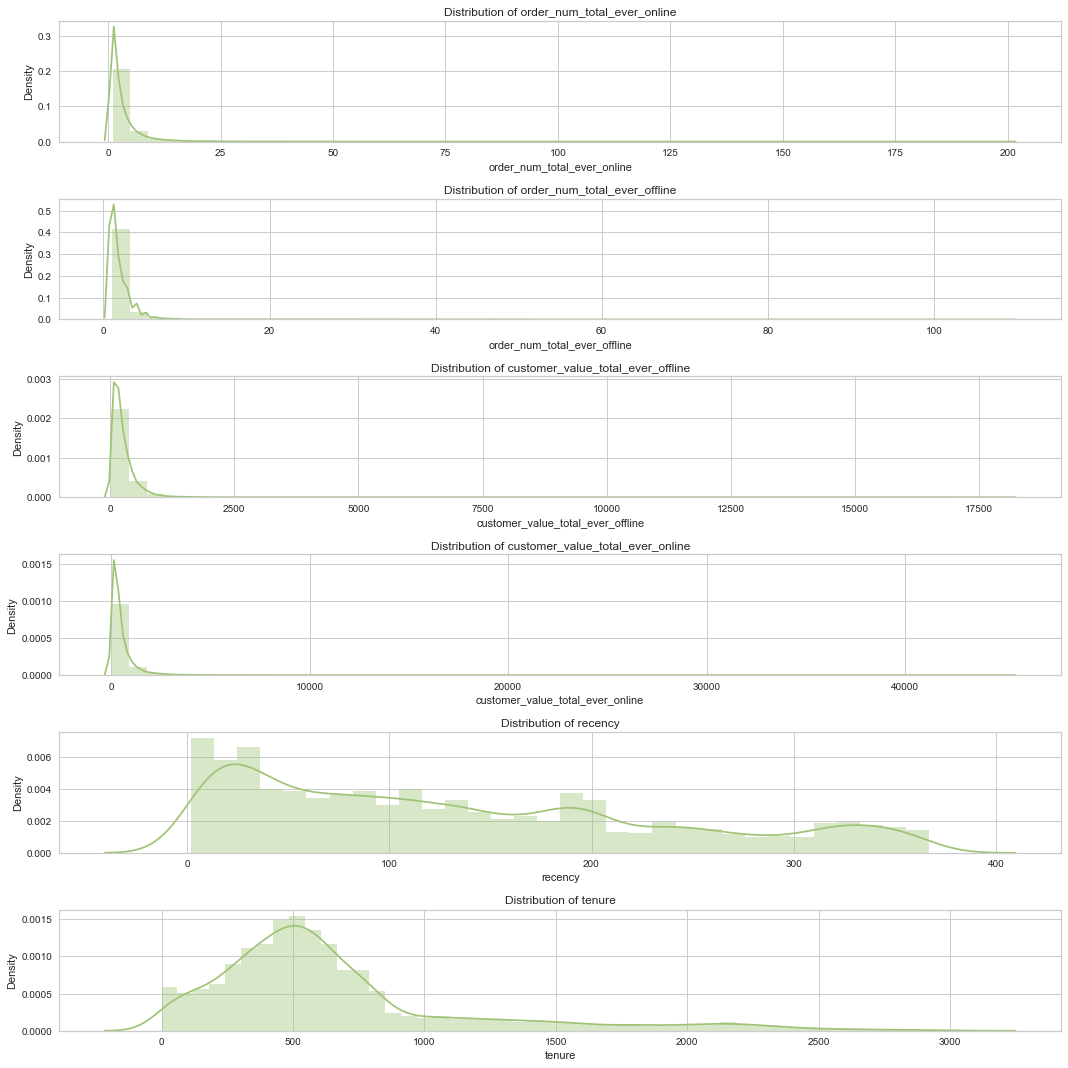

In [23]:
# draw all variables to check & see skewness

plt.figure(figsize=(15, 15))

plt.subplot(6, 1, 1)
check_skew(model_df,'order_num_total_ever_online')

plt.subplot(6, 1, 2)
check_skew(model_df,'order_num_total_ever_offline')

plt.subplot(6, 1, 3)
check_skew(model_df,'customer_value_total_ever_offline')

plt.subplot(6, 1, 4)
check_skew(model_df,'customer_value_total_ever_online')

plt.subplot(6, 1, 5)
check_skew(model_df,'recency')

plt.subplot(6, 1, 6)
check_skew(model_df,'tenure')

plt.tight_layout()
# plt.savefig('before_transform.png', format='png', dpi=1000)   #if you want to save the output image
plt.show()

The distribution of data: Whether the data follows a normal distribution or not is a factor that can influence the functioning of some algorithms. If the data is skewed to the right or left, the model performance may be affected.

If there are scale differences among features, algorithms that use distance-based calculations such as Euclidean or Manhattan distances may produce biased results. In this context, obtaining more accurate results can be achieved by bringing these features to a common data range.

There are methods available to normalize these values and reduce dominance. These methods include normalization and standardization. These techniques are beneficial to apply before using distance-based and gradient-based predictive algorithms.

MinMax Scaling is a scenario where the data takes values between 0 and 1. Here, the distribution aligns with the distribution of the data.

-------------------------------------------------------------------

Verinin dağılımı: Verinin normal dağılıp dağılmaması, bazı algoritmaların çalışmasını etkileyen bir faktör. Veriler sağa yatık, ya da sola yatıksa, model performansı bu durumdan etkilenebilir.

Özellikler arasındaki ölçek farklılıkları iceriyorsa Öklid, Manhattan gibi uzaklık bazlı hesaplamaları kullanan algoritmalar için değerler sapacaktır. Bu bağlamda bu özellliklerin ortak bir veri aralığına çekilmesi ile daha doğru sonuçlar elde edebiliriz.

Bu değerleri normal hale getirmek ve baskınlığı azaltmak adına bazı yöntemler mevcuttur. Bunlar, normalizasyon, standardizasyon gibi metodlardır. Bu metodlar uzaklık tabanlı ve gradyan tabanlı tahminleyici algoritmaları kullanmadan önce uygulanması faydalı olan yöntemlerdir. 

MinMax Scaling, verinin 0 ile 1 arasında değerler aldığı bir durumdur. Burada dağılım, verinin dağılımı ile benzerdir. 


In [24]:
# Applying Log transformation to ensure normal distribution
# Log transformation is a scale transformation method used especially in data sets with right-skewed (pulled to the right) distributions.

model_df['order_num_total_ever_online'] = np.log1p(model_df['order_num_total_ever_online'])
model_df['order_num_total_ever_offline'] = np.log1p(model_df['order_num_total_ever_offline'])
model_df['customer_value_total_ever_offline'] = np.log1p(model_df['customer_value_total_ever_offline'])
model_df['customer_value_total_ever_online'] = np.log1p(model_df['customer_value_total_ever_online'])
model_df['recency'] = np.log1p(model_df['recency'])
model_df['tenure'] = np.log1p(model_df['tenure'])


C:\Users\avcil\AppData\Local\Temp\ipykernel_15336\2890018122.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['order_num_total_ever_online'] = np.log1p(model_df['order_num_total_ever_online'])
C:\Users\avcil\AppData\Local\Temp\ipykernel_15336\2890018122.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['order_num_total_ever_offline'] = np.log1p(model_df['order_num_total_ever_offline'])
C:\Users\avcil\AppData\Local\Temp\ipykernel_15336\2890018122.py:6: SettingWithCopyWarning: 
A value 

"Log transformation is a scaling transformation method commonly used, especially for datasets with right-skewed distributions."

--------------------------------------------------------------------

Log dönüşümü, özellikle sağa çarpık (sağa çekilmiş) dağılımlara sahip veri setlerinde kullanılan bir ölçek dönüşüm yöntemidir. 

In [25]:
model_df.head()

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure
0,1.61,0.69,4.95,6.69,4.56,4.79
1,3.00,1.10,5.08,7.53,4.66,7.29
2,1.39,1.10,5.25,5.98,5.23,5.91
3,0.69,0.69,3.71,4.42,4.91,2.48
4,0.69,0.69,3.93,5.08,4.47,6.37


In [26]:
# Scaling     

sc = MinMaxScaler((0, 1))
model_scaling = sc.fit_transform(model_df)
model_df=pd.DataFrame(model_scaling,columns=model_df.columns)
model_df.head()

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure
0,0.20,0.00,0.34,0.50,0.72,0.60
1,0.50,0.10,0.36,0.60,0.74,0.91
2,0.15,0.10,0.39,0.41,0.86,0.74
3,0.00,0.00,0.18,0.22,0.79,0.31
4,0.00,0.00,0.21,0.30,0.70,0.79


"Log transformation can help correct right-skewed distributions in a dataset. However, even after applying log transformation, in some cases, there may still be a significant variance between the values. In such cases, Min-Max Scaling can be applied. Min-Max Scaling is used to scale values to a specific range, typically [0, 1], aiding in achieving more stable and balanced performance of the model.

By scaling data to a specific range, Min-Max Scaling can contribute to improved performance of algorithms that expect data to be distributed in a certain way."


----------------------------------------------------------------------------------- 
 
 Log dönüşümü, veri setindeki sağa çarpık dağılımların düzeltilmesine yardımcı olabilir. Ancak, log dönüşümü uygulandıktan sonra bile bazı durumlarda değerler arasındaki varyans büyük olabilir. Bu durumda, Min-Max Scaling uygulanabilir. Min-Max Scaling, değerleri belirli bir aralığa (genellikle [0, 1]) ölçeklemek için kullanılır ve bu, modelin daha istikrarlı ve dengeli performans göstermesine yardımcı olabilir.

 Min-Max Scaling, verileri belirli bir aralığa ölçeklendirerek, bu tür algoritmaların daha iyi performans göstermesine yardımcı olabilir.


# K-MEANS MODEL

In order to find an appropriate number of clusters, the elbow method could be be used. Generally, the rule is to choose the number of clusters where we see a kink or "an elbow" in the graph .

---------------------------------------------------------------------------------

Uygun sayıda kümeyi bulmak için dirsek yöntemi kullanılabilir. Genel olarak kural, grafikte bükülme veya "dirsek" gördüğümüz kümelerin sayısını seçmektir.

In [27]:
# I am copying my dataset to use it in the Kmeans model, so that the original version is not corrupted.

k_means_model_df = model_df.copy()

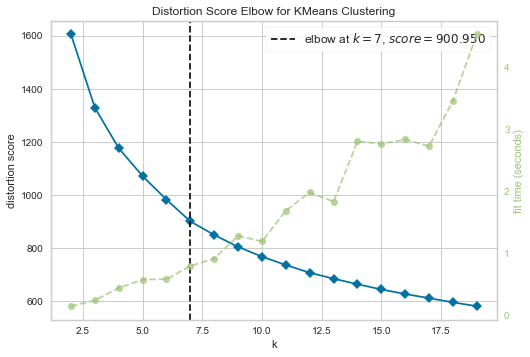

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [28]:
# Determine the optimal number of segments
# Let's see the distribution and decide the optimal number of segments with KElbowVisualizer
  
kmeans = KMeans()
elbows = KElbowVisualizer(kmeans, k=(2, 20))

elbows.fit(k_means_model_df)
elbows.show()

We can see there, k=7. it means, optimal number of cluster is 7.

We build our k_mean model with n_clusters=7

In [29]:
# Create a model 

k_means = KMeans(n_clusters = 7, random_state= 42)
k_means.fit(k_means_model_df)

km_segments = k_means.labels_
km_segments 

# created a total of 7 segments/groups named 0,1,2,3,4,5 and 6

array([6, 6, 6, ..., 1, 2, 0])

In [30]:
# appending labels to data points

k_means_model_df["km_segment"] = km_segments + 1
k_means_model_df.head(10)

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure,km_segment
0,0.20,0.00,0.34,0.50,0.72,0.60,7
1,0.50,0.10,0.36,0.60,0.74,0.91,7
2,0.15,0.10,0.39,0.41,0.86,0.74,7
3,0.00,0.00,0.18,0.22,0.79,0.31,4
4,0.00,0.00,0.21,0.30,0.70,0.79,5
5,0.00,0.10,0.35,0.16,0.69,0.84,5
6,0.15,0.00,0.23,0.39,0.90,0.68,1
7,0.00,0.00,0.21,0.26,0.95,0.56,1
8,0.15,0.10,0.32,0.52,0.70,0.75,7
9,0.00,0.00,0.25,0.24,0.91,0.76,1


In [32]:
# Size of the clusters

size = k_means_model_df.groupby('km_segment').size().to_frame()
size.columns = ["KM_size"]
size

,KM_size
km_segment,
1,5448
2,1841
3,3269
4,828
5,3340
6,1974
7,3245


## Visualization of Clusters:

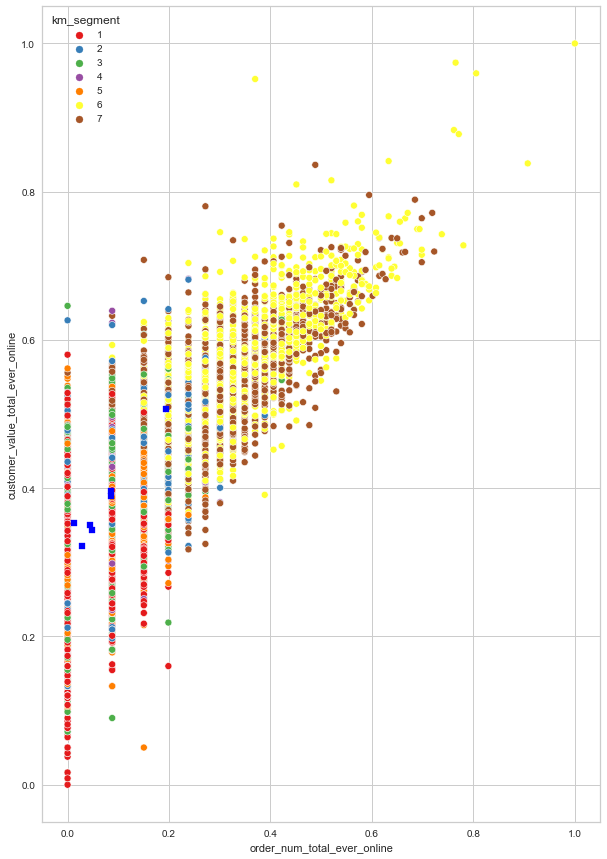

In [34]:
# visualizing the number of online purchases and the amount of online shopping

 
fig1, ax = plt.subplots(figsize=(10, 15))

scat_2 = sns.scatterplot(x='order_num_total_ever_online' , y= 'customer_value_total_ever_online', 
                         data= k_means_model_df, hue='km_segment', 
                         ax=ax, palette='Set1', legend='full')

ax.scatter(k_means.cluster_centers_[:, 1], k_means.cluster_centers_[:, 2], marker='s', s=40, c="blue")
plt.show()

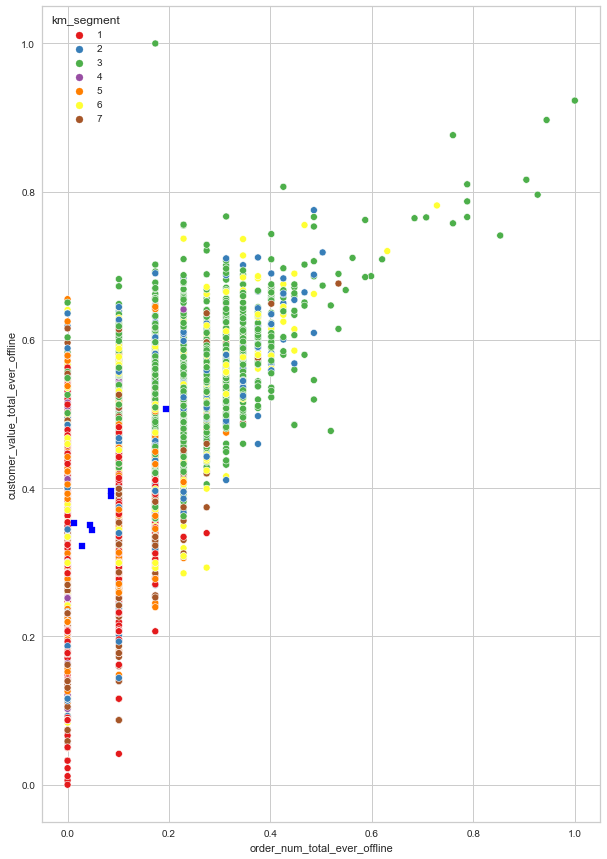

In [35]:
# # visualizing the number of offline purchases and the amount of offline shopping

 
fig1, ax = plt.subplots(figsize=(10, 15))

scat_2 = sns.scatterplot(x='order_num_total_ever_offline' , y= 'customer_value_total_ever_offline', 
                         data= k_means_model_df, hue='km_segment', 
                         ax=ax, palette='Set1', legend='full')

ax.scatter(k_means.cluster_centers_[:, 1], k_means.cluster_centers_[:, 2], marker='s', s=40, c="blue")
plt.show()

#####  Segmentlerin original veri ile birleştirilmiş hali

In [36]:
# We assign the results we find to a new variable named final_df and keep them there

final_df = df[["master_id","order_num_total_ever_online","order_num_total_ever_offline",
               "customer_value_total_ever_offline","customer_value_total_ever_online","recency","tenure"]]

# appending labels to data points
final_df["KM_segment"] = km_segments + 1 
final_df.head()

# this is the final version of the model made with KMeans

C:\Users\avcil\AppData\Local\Temp\ipykernel_15336\1801593392.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["KM_segment"] = km_segments + 1


,master_id,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure,KM_segment
0,cc294636-19f0-11eb-8d74-000d3a38a36f,4.00,1.00,139.99,799.38,95.00,119.00,7
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,19.00,2.00,159.97,1853.58,105.00,1469.00,7
2,69b69676-1a40-11ea-941b-000d3a38a36f,3.00,2.00,189.97,395.35,186.00,366.00,7
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.00,1.00,39.99,81.98,135.00,11.00,4
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,1.00,1.00,49.99,159.99,86.00,582.00,5


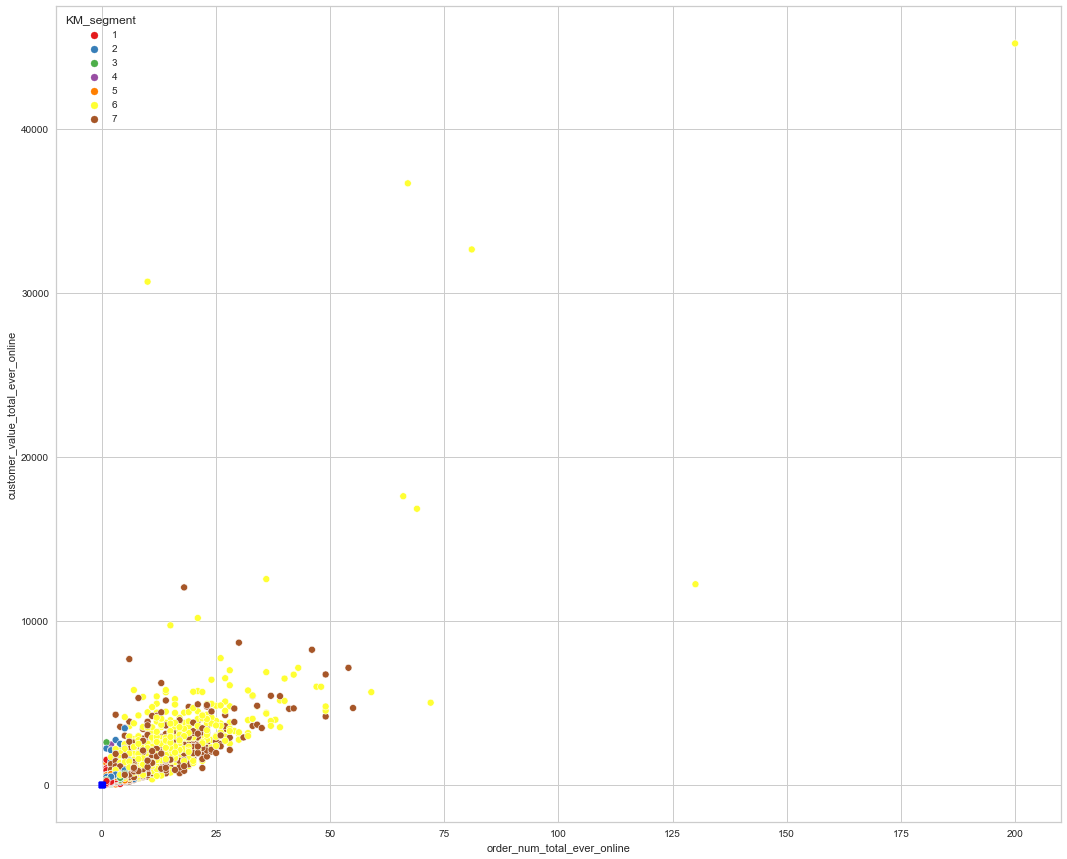

In [37]:
# Visualizing the number of online purchases and amount of online shopping visualized with original data
 
fig1, ax = plt.subplots(figsize=(18, 15))

scat_2 = sns.scatterplot(x='order_num_total_ever_online' , y= 'customer_value_total_ever_online', 
                         data= final_df, hue='KM_segment', 
                         ax=ax, palette='Set1', legend='full')

ax.scatter(k_means.cluster_centers_[:, 1], k_means.cluster_centers_[:, 2], marker='s', s=40, c="blue")
plt.show()

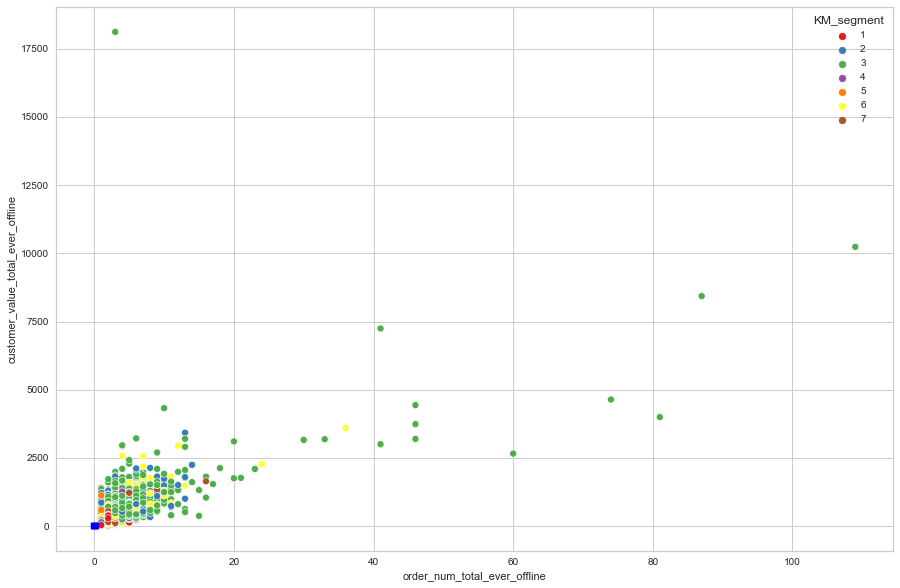

In [38]:
# Visualizing the number of offline purchases and amount of offline shopping visualized with original data
 
fig1, ax = plt.subplots(figsize=(15, 10))

scat_2 = sns.scatterplot(x='order_num_total_ever_offline' , y= 'customer_value_total_ever_offline', 
                         data= final_df, hue='KM_segment', 
                         ax=ax, palette='Set1', legend='full')

ax.scatter(k_means.cluster_centers_[:, 1], k_means.cluster_centers_[:, 2], marker='s', s=40, c="blue")
plt.show()

### Model Statistic

In [39]:
# Let's examine each segment statistically

final_df.groupby("KM_segment").agg({"order_num_total_ever_online":["min","mean","max"],
                                  "order_num_total_ever_offline":["min","mean","max"],
                                  "customer_value_total_ever_offline":["min","mean","max"],
                                  "customer_value_total_ever_online":["min","mean","max"],
                                  "recency":["min","mean","max"],
                                  "tenure":["min","mean","max","count"]})

order_num_total_ever_online             order_num_total_ever_offline             customer_value_total_ever_offline                 customer_value_total_ever_online                  recency               tenure                     
                                   min mean    max                          min mean    max                               min   mean      max                              min    mean      max     min   mean    max    min   mean     max count
KM_segment                                                                                                                                                                                                                                       
1                                 1.00 1.42   5.00                         1.00 1.28   5.00                             10.00 145.16   829.98                            12.99  210.07  1519.17   88.00 225.71 367.00  52.00 489.85 2820.00  5448
2                                 1.00 2.20  12.00                         1.00 2.10  14.00                             12.99 293.82  3425.14                            23.99  377.70  3444.08    2.00  10.00  27.00   2.00 665.01 3031.00  1841
3                                 1.00 1.84  13.00                         1.00 3.77 109.00                            106.82 551.78 18119.14                            14.99  283.36  2587.20   22.00 153.29 366.00  20.00 729.95 2911.00  3269
4                                 1.00 1.40   8.00                         1.00 1.13   6.00                             12.99 192.39  1333.00                            19.99  250.37  3476.81    4.00 139.55 367.00   0.00  37.24  132.00   828
5                                 1.00 1.61   6.00                         1.00 1.48   6.00                             12.99 185.84  1406.85                            14.00  250.00  1307.33   15.00  50.33 109.00  43.00 604.52 2828.00  3340
6                                 2.00 8.63 200.00                         1.00 2.10  36.00                             12.99 278.89  3589.65                           265.97 1475.52 45220.13    2.00  32.72 109.00  18.00 966.63 3034.00  1974
7                                 1.00 6.37  55.00                         1.00 1.54  16.00                             10.49 184.41  1644.79                           180.96  985.51 12038.18   55.00 180.09 367.00  26.00 943.90 2964.00  3245

# Hierarchical Clustering Model

In [40]:
# I am copying my dataset to use it in the Hierarchical Clustering model,
# so that the original version is not corrupted.

hc_model_df = model_df.copy()

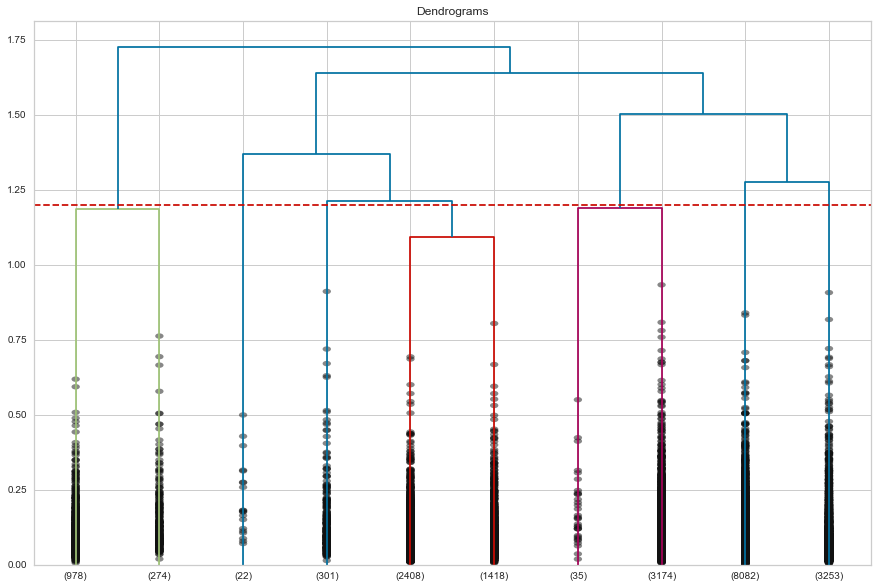

In [41]:
# we will use the data frame we have standardized
# We determine the optimum number of clusters for hierarchical clustering 
# The best way to determine the number of clusters in hierarchical clustering is to draw a dendrogram

hc_complete = linkage(hc_model_df, 'complete')

plt.figure(figsize=(15, 10))
plt.title("Dendrograms")
dend = dendrogram(hc_complete,
           truncate_mode="lastp",
           p=10,
           show_contracted=True,
           leaf_font_size=10)
plt.axhline(y=1.2, color='r', linestyle='--')
plt.show()

Now, we can use the 'AgglomerativeClustering' function from scikit-learn library to cluster the dataset. The AgglomerativeClustering performs a hierarchical clustering using a bottom up approach. The linkage criteria determines the metric used for the merge strategy:

Ward minimizes the sum of squared differences within all clusters. It is a variance-minimizing approach and in this sense is similar to the k-means objective function but tackled with an agglomerative hierarchical approach.


In [42]:
# Create our model
# Segment our customer

hc = AgglomerativeClustering(n_clusters=7)

segments = hc.fit_predict(hc_model_df)

final_hc_df = df[["master_id","order_num_total_ever_online",
               "order_num_total_ever_offline",
               "customer_value_total_ever_offline",
               "customer_value_total_ever_online",
               "recency",
               "tenure"]]

segments
final_hc_df["hc_segment"] = segments + 1
final_hc_df.head()

# this is the final version of the model made with Hierarchical Clustering

C:\Users\avcil\AppData\Local\Temp\ipykernel_15336\2056718978.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_hc_df["hc_segment"] = segments + 1


,master_id,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure,hc_segment
0,cc294636-19f0-11eb-8d74-000d3a38a36f,4.00,1.00,139.99,799.38,95.00,119.00,4
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,19.00,2.00,159.97,1853.58,105.00,1469.00,3
2,69b69676-1a40-11ea-941b-000d3a38a36f,3.00,2.00,189.97,395.35,186.00,366.00,1
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.00,1.00,39.99,81.98,135.00,11.00,4
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,1.00,1.00,49.99,159.99,86.00,582.00,6


In [43]:
# Size of the segments

hc_size = final_hc_df.groupby('hc_segment').size().to_frame()
hc_size.columns = ["HC_size"]
hc_size

,HC_size
hc_segment,
1,5646
2,2510
3,2396
4,985
5,2823
6,3101
7,2484


# Model Statistic

In [44]:
# Let's examine each segment statistically

final_hc_df.groupby("hc_segment").agg({"order_num_total_ever_online":["min","mean","max"],
                                  "order_num_total_ever_offline":["min","mean","max"],
                                  "customer_value_total_ever_offline":["min","mean","max"],
                                  "customer_value_total_ever_online":["min","mean","max"],
                                  "recency":["min","mean","max"],
                                  "tenure":["min","mean","max","count"]})

order_num_total_ever_online             order_num_total_ever_offline             customer_value_total_ever_offline                 customer_value_total_ever_online                  recency               tenure                     
                                   min mean    max                          min mean    max                               min   mean      max                              min    mean      max     min   mean    max    min   mean     max count
hc_segment                                                                                                                                                                                                                                       
1                                 1.00 1.40  13.00                         1.00 2.19 109.00                             10.49 293.63 18119.14                            12.99  222.68 30688.47   33.00 229.93 367.00   3.00 501.81 2820.00  5646
2                                 1.00 4.64  49.00                         1.00 2.41  24.00                             14.99 336.76  3425.14                            23.99  790.85 12545.37    2.00  15.25  86.00  18.00 797.89 3034.00  2510
3                                 1.00 6.91 200.00                         1.00 3.08  16.00                             12.99 427.12  2963.24                           139.98 1104.12 45220.13   14.00 131.57 365.00 109.00 914.49 3016.00  2396
4                                 1.00 1.40   6.00                         1.00 1.20   6.00                             12.99 200.69  1019.97                            26.99  227.42  1389.60    4.00  92.52 367.00   0.00  80.26  555.00   985
5                                 1.00 4.74  24.00                         1.00 1.12   4.00                             10.00 123.46  1049.92                            59.98  722.77  7665.28   36.00 196.52 367.00  71.00 876.95 2964.00  2823
6                                 1.00 1.32   4.00                         1.00 1.61   5.00                             10.99 204.32  1419.98                            14.00  181.46  1307.33   18.00  97.64 322.00 108.00 693.37 2911.00  3101
7                                 1.00 2.86  18.00                         1.00 1.22   4.00                             12.99 144.21   699.97                            19.99  484.78  4129.27    5.00  32.77 108.00  29.00 631.38 2993.00  2484